In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

import math

import re
import nltk
from nltk.corpus import stopwords

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from collections import defaultdict, Counter

from gensim.models import KeyedVectors
from transformers import BertModel, BertTokenizer

import warnings
import logging

warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*get_group.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*n_jobs value 1 overridden.*")

# Adjust logging level for transformers
loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
w2v_file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_name = os.path.join(dirname, filename)
        if file_name.endswith('.bin') or ('.gz'):
            w2v_file = file_name
        else:
            print(f'Found unexpected file: {file_name}')
                
print(f'Google news word to vec file: {w2v_file}')
print(f'{w2v_file} can map words onto vectors with 300 dimensions')

# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")

else:
    print("CUDA is not available.")
    device = torch.device("cpu")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Google news word to vec file: /kaggle/input/GoogleNews-vectors-negative300.bin
/kaggle/input/GoogleNews-vectors-negative300.bin can map words onto vectors with 300 dimensions
CUDA is not available.


# Global Variables

In [2]:
# global variables

w2v = KeyedVectors.load_word2vec_format(w2v_file, binary=True)
vector_dim = 300

corpus = """In the dense rainforest, exotic flowers bloomed amidst lush 
    vegetation, while the nearby desert remained arid and barren. The stark 
    contrast between these ecosystems fascinated ecologists and botanists alike. 
    Meanwhile, in the bustling city, a team of brilliant scientists collaborated 
    on groundbreaking artificial intelligence research, developing algorithms for 
    natural language processing and computer vision. Their work drew attention 
    from tech giants and startups, sparking debates about ethics and privacy. 
    As the sun set, casting long shadows across the urban landscape, a group of 
    friends gathered at a local café to discuss literature, philosophy, and the 
    latest advancements in quantum computing. The aroma of freshly brewed coffee
    mingled with the scent of old books, creating an atmosphere conducive to 
    intellectual discourse and creative thinking. On the outskirts of the city, 
    by the riverbank, a fisherman patiently waited with his rod, while in the 
    financial district, bankers discussed the latest policies affecting the 
    central bank. The word "bank" echoed through different conversations, each 
    with its own distinct meaning."""

# 297 most positive reviews


"""corpus_positive = 
Put this in my husbands stocking for Christmas and it was a hit.
Much hotter than your normal green curry. One pack makes many servings.
What's to say - Pop Chips are great!!!  Kudos to the PoP Chip makers.
It's that good!  Heaven if you like cinnamon.  Tastes sweet with no sugar.
quality food but the price is very high.  luv amazon's free ship over $25.
I KEEP THIS AT WORK AND I MIX IN MY SMOOTHIES AT HOME- LOVE IT!
This is good iced tea. It is hard to find locally in the Fall and Winter.
This is good iced tea.  It is hard to find locally in the Fall and Winter.
Love PG Tips tea.  It's hard to find in the USA, but a standard in the UK.
I love coffee and at night really miss out if I don't have the decaff.
I was glad I ordered this candy. It still taste like it did 20 years ago.
My little guy ate this all up before I could even write a review!  :)
Great snack and good on salads.  It's dried peas, what else can I say?
Unexcelled as to price and equal in quality to the best !
I love this ricemilk.  It has the consistency of almond milk and no soy.
All the dogs on my Christmas list loved this. They ate it right away
they are fabulous and not bad for you, what else could you ask for!
The stuff is great but I'll pay at most $4 or $5 for four bottles.
Very yummy!  My kids and I loved it!  Cute story on the box too!
Healthy plant received on time.  No issues, just the way I like it.  :-)
hot full of lavor great for jerky sauces love it
This will be great with all that I use it for<br /> Thanks, Linda
love it, i always try to tell my friends so they can buy them too
Enjoy this treat on my low carb diet. Nice to have a "chip" to dip
For pork rind lovers these are the best.  Hot, spicy, low fat and crunchy.
I'm on a low sodium diet and this still has plenty of taste without salt
This is the only peanut butter that I eat.  I love the low fat Skippy.
Lipton tea is around $6.75 in the local gorcery store if you cand find it.
Great to send to my son, a college student.  Easy to fix and very tasty.
NEVER MET A DOG THAT DIDN"T LIKE THEM & THEY ARE GOOD FOR THEIR HIPS!
great product  fresh and delivered on time  will buy again  k
I like pop-tarts, and a pack of 12 is a convenient way to house them.
Very quick in getting my order to me.  Would order from them again
I love this seasoning for my chicken. So easy to make too! Great stuff!!!
This soup makes the greatest Pampered Chef Mediterranean Salad Dressing!
Our 8 yr old with celiac loves this cracker. Great with soup or for PB&J.
Smoothest green tea yet....good all day
This is the best hot sauce around.  We use it in everything we make.
Ordered rice for my wife, I got the wrong blend but she likes it anyway.
This is a really good mix.  They really are as good as the wheat brownies.
This product is easy to use for all baking and it tastes just like sugar!
it is an excellent spread.  nutella and peanut butter sandwiches rule.
I really like to put this on top of the coffee before brewing.  Yummy!
This is the best jerky I've ever eaten and makes a great snack for travel.
My dogs just love this food. The service is always fast and reliable.
Babys loves this one and so do I.  Love the packaging to- no jars to wash.
Nice decorative box of variety teas--great to use or give as a small gift.
Yes, it is HOT, but very flavorful.  I am totally addicted to this stuff.
open add milk eat throw away<br />all I needed was a spoon in the morning
was way to hot for my blood, took a bite and did a jig  lol
It doesn't take long to get your morning  wake up with Paul's Bold Blend
The best of the decaf blends in the K-Cup series
This is a real treat for coffee lovers - a little pricey, but worth it.
Best chips I've ever eaten but you should sell them in 11 to 15 oz bags.
The flavor is very good and the guests I served it to, thought so also.
Nice and simple, basic tadka daal! You cant go wrong with it.
as soon as i bought this i could stop eating them there are so good
I love this in Miso Soup, and this is the only place I could find it.
I love these but you can get 5  5.1Oz bags at wall mart for $17 dollars
I love Hot Coco and this is by far the best I have tasted.
best popcorn i have ever made. got to go order more so you do the same !!!
I KEEP THIS AT WORK AND I MIX IN MY SMOOTHIES AT HOME- LOVE IT!
This is good iced tea. It is hard to find locally in the Fall and Winter.
This is good iced tea.  It is hard to find locally in the Fall and Winter.
I love this bar it's a great to in between meals. Low in fat only 150cal.
I got the product in time and it is exactly what I expected it to be.
I love this bar it's a great to in between meals. Low in fat only 150cal.
love it.  taste like the old days at the show, when i was a boy
Very hard to find this favor in the stores, I was glad to find it.
Of all the gluten free breads I've tried, this one is the best by far.
Best chips I've ever eaten but you should sell them in 11 to 15 oz bags.
THIS IS THE BEST HONEY YOU WILL EVER TASTE<br /> I HOOKED ON IT!
This is the best.  Great taste and yummy, like eating dessert.  Love it.
I like the zip closing on the 15 pound bag.  the cats like it too! :)
NEVER MET A DOG THAT DIDN"T LIKE THEM & THEY ARE GOOD FOR THEIR HIPS!
My favorite gum --- it's been hard to find in retail stores.  Great price!
This is the best syrup we've tried so far and we will be buying it again.
I paid twice this with my Vet great price and my  dogs love them
They are yummy.  Taste like cheetos but not as bad for you.
I am addicted!  I cannot stop eating this stuff.  Great product.
I shopped by price and this was far and away the best price out there.
These biscuits are a favorite of both of my dogs.  The price is great!
This tea is excellent and we drink it all the time. It is well priced.
I like this dressing that I take to work with a salad.  I will buy again.
This is a great healthy snack for kids.  My 10 year old loves them.
Do U like BBQ beef snacks??? Then buy this one, I think you'll love it.
I enjoy saffron a lot, it is an awsome herb
This is the best tea.  I like it as well as coffee.  Highly recommend it!
I enjoy saffron a lot, I find it very exotic.
This was so easy to make & great for you also.  can't wait to order more.
This is their best flavor and hard to find in stores.  I love it.
This stuff is really good, but a 2 ounce box contains 8g of trans fat.
Easy to carry this delicious honey around - in your purse or pocket.
my dog just loves your products if my dog is happy im happy.
This is the best soup.  But hard to find.  Low in calories Great taste!
Our area has become devoid of PEZ refill packs. So this is a good deal.
This coffee has an EXCELLENT flavor.  We LOVE our Keurig one-cup brewer!
What a great deal!!!  I love having it sent right to my house monthly!!!!!
These are the best nuts ever and the value is best with the 6 pack.
PG TIPS IS ABSOLUTELY THE BEST TEA FOR THE MONEY THIS SIDE OF THE POND.
Love the taste !  It fillls the office with a wonderful aroma
The coffee shown is great tasting and quick for those on the go!
I think this is one of the best to my taste.
not loaded with salt like some spice blends.  we enjoyed it quite a bit.
Yummy, if you like noodles I recomend these.
The product seems to be high quality and the service is great.
Unexcelled as to price and equal in quality to the best !
Best dark chocolate ever, I wish it was stocked well at amazon
My wife makes a shepard pie with this & the wholesome taste is so good.
Great taste and no sugar. My gym turned me on to these and they are great.
Great for iced tea.  Same tea used at Starbucks for their iced green tea.
Fast shipping.  I would buy from this store again.  Thank you.
I love this decaf tea!  I love the convenience of ordering it by the case.
These are the best nuts ever and the value is best with the 6 pack.
my dog just loves your products if my dog is happy im happy.
My dogs have been on this food for three years and are doing very well.
Great product would definitely buy again m n o p q r s t u v w x y z
My dog loves these and they are good for her; all natural and low fat.
My dog loves it and it's good for him.  So, I keep buying this stuff.
This is the best jerky I've ever eaten and makes a great snack for travel.
These are one of my dog's FAV's. I am glad I can get them through Amazon.
My dogs love these treats. They taste good and much healthier for them.
I love the variety of the sampler and the convenience of the pods.
The flavor is very good and the guests I served it to, thought so also.
This product is great, full of flavor and so easy to make.
We love Cincinnati chili!  This is a quick easy way to have lots of chili.
Love this pancake mix.  This is the only brand we have used n years.
Gummi candy is great and it doesn't get any better than Haribo.
We love these.  Buy them by the case.  Great healthy (but tasty) snack
We brought the chips and bake a birthday treat for our dog.  It was great.
I love this delicate pink salt.  It is by far my favorite type of salt.
Love these bars and what a great bargain I got on them, too!  Thanks.
Have been buying this a the local store... great product.
Been using this product for over a year. Excellent. My cat thinks so too.
Great treat for my dog!  She loves them and they don't put weight on her.
It came 2 days prior to the estimated delivery date, so I was very happy.
I love this product! It does what it says it will do with no side effects.
my husband will eat a whole box of these in one sitting, they are awesome!
A tea that's sweetish and flavorful in a natural and spicy way.
This is the best orange spice tea I have ever had.  Lots of flavor.
This is the best orange spice tea I have ever had.  Lots of flavor.
This is the best chili oil ever. you can us it on anything and i do.
This is the best tea.  I like it as well as coffee.  Highly recommend it!
YUMMY!!!<br /><br />I could eat these all day! Delicious feel good food.
as good as in the cans quick and easy in micro, good for a snack meal
I actually put this in my ice water and it gives it a nice flavor.
This has to be one of the best flavored teas that I have tried!
This is tea as it should be.  Not like some of our US cheap stuff.
<span class="tiny"> Length:: 0:42 Mins<br /><br /></span>
I really like to put this on top of the coffee before brewing.  Yummy!
There is not much to be said. Totally satisfied.<br /><br />Dr. Peter Rohr
Got the raisins, and they were what I expected.  Thanks!
This is one the best spiced Chai teas I have ever purchased.
This is some of the best tea I have had.  I will buy more when I run out.
This item is no longer in the stores, was so glad I found it on Amazon.
love it, i always try to tell my friends so they can buy them too
Enjoy this treat on my low carb diet. Nice to have a "chip" to dip
For pork rind lovers these are the best.  Hot, spicy, low fat and crunchy.
Smoothest green tea yet....good all day
I so Miss being able to get Butternut Coffee I can not get it Florida
its sooo good. yummy, filling, natural. what more could you ask for!
They have no added sugar or honey unlike most of the bars, just the dates.
I like this apple pie bar - good blend of flavors.  YUM
Great tasting bar. Nice and soft make it easy to eat.
I have one daily and I have one in my purse at all times. !
This is the best orange spice tea I have ever had.  Lots of flavor.
I got the product in time and it is exactly what I expected it to be.
Tastes good. Fruit juice sweetened. Excellent ingredients.
best store cookie I have ever tasted & carefully selected ingredients.
My son loves these.  Easy, gluten free item to put in his lunch bag
the irish rashers were great just like what we had in ireland this summer
The first time I ordered i it was $16  the next time  $21  it is tasty
It's nice to know there's a Brand you can always count on for quality.
Good heat - good flavor and character for everyday use.
This is the best we have found to date.  We'll be back again very soon.
I have used other brands and this is by far the best tasting.
I LOVE THE TART FLAVOR OF THIS PRODUCT.  I HAVE PURCHASED IT  MANY TIMES.
My dogs love these treats. They taste good and much healthier for them.
This is the best tea.  I like it as well as coffee.  Highly recommend it!
This is the only food that my Golden eats as soon as I put it out for him.
This is the only food that my Golden eats as soon as I put it out for him.
This is the best Tea out there. But it is hard to find on Amazon!!!
my dog just loves your products if my dog is happy im happy.
My dogs have been on this food for three years and are doing very well.
Rice bran is a healthy way for those on a gluten free diet to get fiber.
Does not state in any of your ads how many cans you get. Please clarify.
Been using this product for over a year. Excellent. My cat thinks so too.
These were my kids favorite.  No orange mess and a light crunchy texture.
These are the best nuts ever and the value is best with the 6 pack.
This is a terific sauce for faijitas!  Highly recommended.
Tasty and a bit out of the ordinary.  It's nice to be able to get it here.
I love coffee and at night really miss out if I don't have the decaff.
I love this soda.  I wish I could find a store where I live that sells it.
Have tried many products this is by far the best Rice Pasta!
Stronger than some others but you can't stop at just one cup !
This was a gift.  I was told it arrived on time and was a quality product.
I like this gum. Since I have been using it I have had no cavaties.
This is the only food that my Golden eats as soon as I put it out for him.
Sourwood is my fav honey but this is a very close 2nd.  Good price too!
These taste as good as any gummy.<br />I will try other flavors next time.
Do U like BBQ beef snacks??? Then buy this one, I think you'll love it.
I was a bad girl.  Love a Heath Bar I do.  Amazon service is always great.
Way too yummy and now i need to spend way too much time in the gym :+#
IF YOU LIKE SALMON YOU WILL LOVE THESE OMAHA STEAKS SALMON VERY VERY GOOD
GOOD FLAVOR ... GOOD PRICE ... JUST WISH IT WAS OFFERED IN DECAF!
Add a can of red kidney beans to get the most out of this entree.
i cannot say enough good things about this product - i am addicted to them
I feel like a kid in a candy store with my box of chips... lol great!
this is great to toss in my bag and have for me or my little girls
I double them so that I get twice the enjoyment. Makes great spring rolls
I call them "my healthy candy "  I also like the apple ones .
Tulsi Green tea has a great lavor and is good as iced tea as well.
This is one of the best and safe products made in the USA
If you like to dunk your cookies, look no more! They melt in your mouth!
The best peanut butter ever, very crunchy.  Wish it came in a large size.
These are the best nuts ever and the value is best with the 6 pack.
Got a lot more for my money than expected. Use this in soup, love it!
I sent this as a gift.  My BFF loved it, thought it was beautiful.
This is simply one of the best vinegar for the price. I am truly addicted.
Good cereal at a great price.  I love this flavor, and so do the kids!
This is the best of the sugar free Ross candy that I have found so far.
its sooo good. yummy, filling, natural. what more could you ask for!
They have no added sugar or honey unlike most of the bars, just the dates.
I like this apple pie bar - good blend of flavors.  YUM
Great tasting bar. Nice and soft make it easy to eat.
I have one daily and I have one in my purse at all times. !
Excellent, will buy again everything is fresh and the best is the variety
I love these noodle.  A little to spicy for the wife but perfct for me.
I just love it and will buy another box when I'm done with last one!
They are very attracted to this cat nip.  It's very potent.
my dogs tell me that they are very good and good for their health..
As close as you can possibly get to the German Quark here in the States.
I love not having to go to the store just because I ran out of coffee.
This coffee is just the way I remembered it from way back in the 1940's.
very good product good flavorand  (no msg)<br /><br />  thanks PS
i cannot say enough good things about this product - i am addicted to them
This is a very good item.<br />I will my friends about this great buy.
These are the best nuts ever and the value is best with the 6 pack.
great curry<br />easy to use and tastes good<br />i would buy it again
I liked the product for years and glad to find it for less money in bulk.
Just a wonderful cup of green tea.  What more needs to be said?  Enjoy!
Tastes great and the price was good.
<span class="tiny"> Length:: 4:34 Mins<br /><br /></span>
This is excellent.  I lke bold taste AND NO BITTERNESS TO IT AT ALL!
Tastes great and the price was good.
I use these for my travel mug and set it to 12oz. The perfect cup.
I love this product it keep me out of the store buying milk all the time.
This is a great way to taste different brands. I have such fun with it.
We have Italian herbs!  Grew just as expected.  We love it.
One of the easiest of the kits to grow. The herb kits are also good.
Babys loves this one and so do I.  Love the packaging to- no jars to wash.
Used one pod for the big mug - not too strong and really good flavor.
Excellent!!! Very fresh and very very good licorice. Highly recommend
<span class="tiny"> Length:: 4:34 Mins<br /><br /></span>
These treat are the best I have found in years and my dogs love them.
This tea is great. My husband doesn't like tea but he loves this like me.
it's the truth.  two big a$$ tubs and it tastes just like back in the day.
this is cute gum but it was too big to put in my gumball machine.
This is very good tea as well as easy to use.  I love the taste.
This is an excellent review.  I even use it when I make cucumber salad.
This is the best tea you can buy.  The English really know their tea!
This is the best jerky I've ever eaten and makes a great snack for travel.
This is a good tasting product at a good price and I will buy it again!!
love it.  taste like the old days at the show, when i was a boy
great quality. I just wilsh I had bought more as it came in 1 lb packages.
This is a awesome hot mustard. I have been using it since I was young.
$4.99 - when i can buy it in the local store for $2.79?? I don't think so.
Recommended.  Good price when bought in bulk.
I like this product and would by more if I could.
My dogs love these Nylabones and the price is better than at a pet shop.
best falafel in a box out there.  just add water and fry 'em up.
Sent as a Christmas gift, they received it on time and loved it
This is the best pea soup mix.  The spice balance is just right.
One of the best teas out there! It will get you going all day long !!!
Loved them and they were received in Excellent condition!
If you haven't tried this you must order it now. That's how good it is...
I have not used this Gel Paste yet but I can't wait to try it out. . . . .
My dogs have been on this food for three years and are doing very well.
I was not sure about the butter, but I love it and so do my customers!
I am an Earl Grey drinker and his product has excellent taste and aroma.
A good example that the taste of organic food is better!
This is a great, fast, family meal.  I have the subscribe n save plan.
good stuff .... not a lot of peanut in it but it i good and chewy
This can add a floral note to tea, coffee, etc. and brighten up your day.
Not for sale where I live, I order it by the case.  Good stuff.
Not too strong, but full of taste. Great price, convenient delivery.
As good as unsalted soy nuts can be: fresh and tasty with a light crunch.
These are the best nuts ever and the value is best with the 6 pack.
My daughter loves it! I do not understand why can't I buy it in a store.
Recommended.  Good price when bought in bulk."""

# 167 short most negative reviews

​
"""corpus_negative = 
Arrived in 6 days and were so stale i could not eat any of the 6 bags!!
I won't buy it again and will donate the whole box to the Food bank.
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
It didn't work well for me in the microwave. Will not purchase a 2nd time.
This coffee was very bitter.  Not my cup of coffee
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Limp, soggy, little taste. Not a bit like real pad Thai.
The product was wet in the tube as if the tube was not seiled correctly.
IF YOU LIKE YOUR POPCORN SMALL AND CRUNCHY, THIS IS FOR YOU.  I DON'T.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
i just purchased this same candy for 75 cents each 5 oz box from wal-mart.
I bought these as a gift and even though they are funny they taste awful!
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
I pay $2.50 a can for this at the gas station, this doesn't make sense.
The same item at stop and shop for 2.19$ x12 =26.28  Save you money
my dog loved them. I can not stand the, this is not jerky at all.
I found this under a search for gluten free foods and this is NOT gf.
Awful taste it was soft and airy I fed it to my dogs.
Candy was old and nearly broke my teeth.  Don't waste your time or money.
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
It didn't work well for me in the microwave. Will not purchase a 2nd time.
The price for this item is three times what you would pay at the store.
Have not received this item so I can't write a review!  Where is it?
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
I did not like these at all.  The price is too high in my opinion, too.
Kitty would not eat this.  We gave the whole pack to our animal shelter.
Only two of the seven herbs grew.  I was not satisfied with this product.
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
IF YOU LIKE YOUR POPCORN SMALL AND CRUNCHY, THIS IS FOR YOU.  I DON'T.
I never received this item because you never got it in to ship to me.
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
This must be a typeo or this is the most expensive pod coffee ever.
This stuff does not taste good.  That makes it hard for me to drink.
I never received this item because you never got it in to ship to me.
These do not ship well. I got them in the huge box and they were ruined.
This stuff does not taste good.  That makes it hard for me to drink.
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
I sorry to have to say this but we did not like them at all
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
The worst beef I have ever tasted. Omaha gave me my money back via Amazon.
The worst beef I have ever tasted. Omaha gave me my money back via Amazon.
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
I drink black coffee and this is not the one you want to drink in black.
I received only 1, not 4.  I think they have a mistake in their system.
Kitty would not eat this.  We gave the whole pack to our animal shelter.
I picked up a 1 Oz tin of same brand for 14.99 in Dallas area
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
I got the 5 lbs bag.  Received it right away but this has too many shells.
Many biscuits were broken and appeared stale.  My dogs did not like them.
this stuff is  not stuffing  its  not good at all  save your money
Did not receive item, so have no idea how it would or would not perform.
Did not receive item, so have no idea how it would or would not perform.
Kitty would not eat this.  We gave the whole pack to our animal shelter.
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
Only two of the seven herbs grew.  I was not satisfied with this product.
I bought one of these to give to my dying grandfather. He did not recover.
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
The product was wet in the tube as if the tube was not seiled correctly.
If you want to spend your money on water and salt, go ahead, buy it...
I had goat milk from a carton and it is way better.<br />In a car horrid.
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Don't know why this is here as I never purchased this item.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
This product came to me packed in bags, not cans. Disappointed.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
This stuff does not taste good.  That makes it hard for me to drink.
I never received this item because you never got it in to ship to me.
I guess you get what you pay for. Full of crab shells and no flavor.
if you can eat 4 boxes in two days there ok. i will never buy again!!!!!
No one liked them. they had an aftertaste and were too hard to eat.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Don't know why this is here as I never purchased this item.
I have not received this item.  I hope to like it when I do.
I got the 5 lbs bag.  Received it right away but this has too many shells.
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
I got the 5 lbs bag.  Received it right away but this has too many shells.
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Shipping costs are VERY high for this product - $16.16 for a 6 lb. box
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
I got the 5 lbs bag.  Received it right away but this has too many shells.
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
This product is just a pint of maple syrup priced as if it were a quart.
I tried 3 times this bread mix, it dosen't rise and taste not so good.
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
Awful taste it was soft and airy I fed it to my dogs.
Kitty would not eat this.  We gave the whole pack to our animal shelter.
Awful taste it was soft and airy I fed it to my dogs.
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
Many biscuits were broken and appeared stale.  My dogs did not like them.
Not even close, nobody cared for it, now I have a case to get rid of! Ugh!
Awful taste it was soft and airy I fed it to my dogs.
Not worth it
I was sent the wrong item twince. I still do not have the item I ordered.
I bought this to go with a cheese sampler for a party. It was inedible.
I found the taste to to too salty & overpowering. Not a great snack choice
<span class="tiny"> Length:: 1:30 Mins<br /><br /></span>
This stuff does not taste good.  That makes it hard for me to drink.
just plain GROSS!  They taste a little chewy and had a weird smell.
These were the worst candy fish I have ever had. I had to throw them away.
It is very mushy and has a really strange flavor. I could not gag it down.
Awful taste it was soft and airy I fed it to my dogs.
I'm not happy with it as I didn't even receive it!
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
if you can eat 4 boxes in two days there ok. i will never buy again!!!!!
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
My cat wouldn't touch this stuff. I wound up giving it to the ASPCA.
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
I never received this item because you never got it in to ship to me.
I hate the new taste of the new flavor please return to the old one
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Don't know why this is here as I never purchased this item.
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
I couldn't finish it.  The flavor made me sick.  It just tastes wrong...
The  mix is liquid and is not worth the money.  ratio to water is too much
The item listing says it's a "pack of 6" but they only send you one.
It didn't work well for me in the microwave. Will not purchase a 2nd time.
my dog loved them. I can not stand the, this is not jerky at all.
This is so good I wish it comes in a bigger package!
Are you supposed to avoid sugars if you have a urinary tract infection?
This tea tastes nasty.  Maybe I just dont like sage but it made me gag!
Kitty would not eat this.  We gave the whole pack to our animal shelter.
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
I didn't like it, and no one in my house liked. It doesn't taste good.
Coffee is very weak,I have to use 3 packs to make 4 cups of coffee.
I purchased this as a gift, I am told that the tea's had a horrible taste!
Was sorry to find out that I am not able to order and we are neighbours.
What is going on here?  Why is a 6 oz bag of treats so much?
I never received this item because you never got it in to ship to me."""

# Tokenizer

In [3]:
def tokenizer(text):
    """Tokenize and remove the stop words from the text"""
    # Download the stopwords & get list of stop words for English
    # nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    
    # tokenize text
    tokens = re.findall(r'\w+', text.lower()) # tokens = nltk.word_tokenize(text.lower())
    
    # Remove stop words and count occurrences
    removed_stop_words = Counter(word for word in tokens if word in stop_words)
    filtered_text = [word for word in tokens if word not in stop_words]
        
    return tokens, filtered_text

# Embeddings:

## Random

In [4]:
def get_random_embeddings(words):
    """Generates random embeddings for the given words."""
    random_vectors = []
    for token in words:
        random_vectors.append(np.random.rand(vector_dim))
    return np.array(random_vectors), words

## W2V/Semantic

In [5]:
def get_w2v_embeddings(words, w2v_model):
    """Retrieves Word2Vec embeddings for the given words."""
    w2v_vectors = []
    for token in words:
        if token in w2v_model.key_to_index:
            w2v_vectors.append(w2v_model[token])
        else:
            w2v_vectors.append(np.zeros(vector_dim))
    return np.array(w2v_vectors), words

## BERT/Contextual 

In [6]:
def get_attention_embeddings(words, max_length=512):
    """
    Generates attention embeddings using a pre-trained BERT model.
    
    Slighly modified to account for BERT's 512 token limit
    """
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    all_embeddings = []
        
    # Split input into chunks of max_length tokens
    for i in range(0, len(words), max_length):
        chunk = words[i:i + max_length]
        input_ids = tokenizer.encode(chunk, add_special_tokens=False, return_tensors='pt')
         
        with torch.no_grad():
            outputs = model(input_ids)
            attention_embeddings = outputs.last_hidden_state.squeeze(0).numpy()
            all_embeddings.append(attention_embeddings)
    
    # Concatenate all embeddings
    return np.concatenate(all_embeddings, axis=0)

## Custom Transformer Encoder

In [7]:
# HyperParameters for the module
d_model = 300  # Should match the embedding dimension of our word embeddings
seq_len = 100  # Maximum sequence length
input_size = d_model  # based on the output size of our feed-forward network

num_layers = 10 # Number of encoder layers
num_heads  = 50 # number of attention head
d_ffn   = 2048 # dimension of the feedforward layer

dropout = 0.0 # we can adjust the dropout if needed
eps = 1e-6 # epsilon value to prevent the standard deviation from becoming zero

"""
To ensure compatibility, it's important to choose the
number of attention heads (h) such that d_model is
evenly divisible by h in the multi-head attention
module's self.d_k. This allows for a clean distribution
of the model dimensionality across the attention heads.
"""

# d_model / attn.h = 300 / 30 = 10

class MultiHeadedAttention(nn.Module):
    def __init__(self, h: int, d_model: int, dropout: float = 0.0):
        super().__init__()

        self.d_model = d_model
        self.h = h
        self.d_k = d_model // h

        self.query_linear = nn.Linear(d_model, d_model)
        self.key_linear = nn.Linear(d_model, d_model)
        self.value_linear = nn.Linear(d_model, d_model)
        self.output_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(p=dropout)

    @staticmethod
    def scaled_dot_product_attention(query, key, value, mask=None, dropout=None):
        """
        Compute the scaled dot-product attention.

        Args:
            query: Tensor of shape [batch_size, h, seq_len, d_k].
            key: Tensor of shape [batch_size, h, seq_len, d_k].
            value: Tensor of shape [batch_size, h, seq_len, d_k].
            mask: Optional mask tensor of shape [batch_size, 1, seq_len, seq_len].
            dropout: Optional dropout layer.

        Returns:
            attention_output: Tensor of shape [batch_size, h, seq_len, d_k].
            attention_weights: Tensor of shape [batch_size, h, seq_len, seq_len].
        """
        d_k = query.size(-1)
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

#         if mask is not None:
#             # Ensure mask has the same shape as attention_scores
#             mask = mask.unsqueeze(1)  # Add dimension for heads first
#             # Then expand to match attention_scores
#             mask = mask.expand(-1, query.size(1), -1, -1)
#             attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))

        attention_weights = torch.softmax(attention_scores, dim=-1)

        if dropout is not None:
            attention_weights = dropout(attention_weights)

        attention_output = torch.matmul(attention_weights, value)

        return attention_output, attention_weights

    def forward(self, query, key, value, mask=None):
        """
        Compute the multi-headed attention.

        Args:
            query: Tensor of shape [batch_size, seq_len, d_model].
            key: Tensor of shape [batch_size, seq_len, d_model].
            value: Tensor of shape [batch_size, seq_len, d_model].
            mask: Optional mask tensor of shape [batch_size, seq_len, seq_len].

        Returns:
            output: Tensor of shape [batch_size, seq_len, d_model].
        """
        batch_size = query.size(0)

        query = self.query_linear(query).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        key = self.key_linear(key).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        value = self.value_linear(value).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)  # Add a dimension for h

        attention_output, _ = self.scaled_dot_product_attention(query, key, value, self.dropout)

        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        output = self.output_linear(attention_output)

        return output
    
class LayerNorm(nn.Module):
    def __init__(self, features: int, eps: float = 1e-6):
        """
        Construct a layernorm module.

        Args:
            features: Number of input features.
            eps: Small value added to the denominator for numerical stability.
        """
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        """
        Apply layer normalization.

        Args:
            x: Input tensor of shape [batch_size, seq_len, features].

        Returns:
            Normalized tensor of the same shape as the input.
        """
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model: int, d_ffn: int, dropout: float):
        """
        Construct a position-wise feed-forward network.

        Args:
            d_model: Dimension of the input embeddings.
            d_ffn: Dimension of the feed-forward network.
            dropout: Probability of dropout.
        """
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ffn)
        self.w_2 = nn.Linear(d_ffn, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Apply the position-wise feed-forward network.

        Args:
            x: Input tensor of shape [batch_size, seq_len, d_model].

        Returns:
            Output tensor of shape [batch_size, seq_len, d_model].
        """
        return self.w_2(self.dropout(torch.relu(self.w_1(x))))
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, h: int, d_ffn: int, dropout: float):
        """
        Construct an encoder layer.

        Args:
            d_model: Dimension of the input embeddings.
            h: Number of attention heads.
            d_ffn: Dimension of the feed-forward network.
            dropout: Probability of dropout.
        """
        super().__init__()
        self.self_attn = MultiHeadedAttention(h, d_model, dropout)
        self.feed_forward = PositionwiseFeedForward(d_model, d_ffn, dropout)
        self.sublayer = nn.ModuleList([LayerNorm(d_model) for _ in range(2)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Apply the encoder layer.

        Args:
            x: Input tensor of shape [batch_size, seq_len, d_model].

        Returns:
            Output tensor of shape [batch_size, seq_len, d_model].
        """
        sublayer_output = self.self_attn(x, x, x)
        x = x + self.dropout(sublayer_output)
        x = self.sublayer[0](x)
        sublayer_output = self.feed_forward(x)
        x = x + self.dropout(sublayer_output)
        x = self.sublayer[1](x)
        return x


class StackedEncoder(nn.Module):
    def __init__(self, num_layers: int, d_model: int, h: int, d_ffn: int, dropout: float):
        """
        Construct a stacked encoder.


        Args:
            num_layers: Number of encoder layers.
            d_model: Dimension of the input embeddings.
            h: Number of attention heads.
            d_ffn: Dimension of the feed-forward network.
            dropout: Probability of dropout.
        """
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, h, d_ffn, dropout) for _ in range(num_layers)
        ])
        self.norm = LayerNorm(d_model)

    def forward(self, x):
        """
        Apply the stacked encoder.

        Args:
            x: Input tensor of shape [batch_size, seq_len, d_model].

        Returns:
            Output tensor of shape [batch_size, seq_len, d_model].
        """
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

In [8]:
def process_embeddings_with_encoder(embeddings, encoder):
    tensor_data = torch.tensor(embeddings, dtype=torch.float32)
    data_loader = DataLoader(tensor_data, batch_size=len(tensor_data), shuffle=False)
    
    encoded_reviews = []
    with torch.no_grad():
        for reviews in data_loader:
            reviews = reviews.to(device)
            encoded_batch = encoder(reviews)
            encoded_reviews.append(encoded_batch)
    
    encoded_reviews_tensor = torch.cat(encoded_reviews, dim=0)
    encoded_reviews_tensor = encoded_reviews_tensor[:, 0, :]
    return encoded_reviews_tensor.cpu().numpy()

In [9]:
# stacked_encoder = StackedEncoder(num_layers, d_model, num_heads, d_ffn, 
#                                  dropout).to(device)
# encoded_reviews = []
# corresponding_ratings = []

# batch_counter = 0

# with torch.no_grad():
#     for reviews, ratings, mask in data_loader:
#         print(f'Size of batch: {reviews.shape}')
#         batch_counter += 1
#         print(batch_counter)

#         reviews = reviews.to(device)
#         encoded_batch = stacked_encoder(reviews, mask)

#         encoded_batch = encoded_batch.cpu()  # Move the encoded batch to CPU
#         ratings = ratings.cpu()  # Move the ratings to CPU

#         encoded_reviews.append(encoded_batch)
#         corresponding_ratings.append(ratings)

#         # Free up GPU memory
#         del reviews
#         # del pe_encoded_reviews
#         del encoded_batch
        
#         torch.cuda.empty_cache()

# encoded_reviews_tensor = torch.cat(encoded_reviews, dim=0)
# ratings_tensor = torch.cat(corresponding_ratings, dim=0)

# print(f'Size of Reviews: {len(encoded_reviews_tensor)} tensors')
# print(f'Size of Ratings: {len(ratings_tensor)} tensors')
# print(f'Shape of Reviews: {encoded_reviews_tensor.shape}')
# print(f'Location of Reviews: {encoded_reviews_tensor.device}')
# print(f'Location of Ratings: {ratings_tensor.device}')

# Graphs:

## 2D / 3D t-SNE

In [10]:
def visualize_embeddings_tsne(embeddings, words):    
    tsne_2d = TSNE(perplexity=30, n_components=2, random_state=42)
    tsne_3d = TSNE(perplexity=30, n_components=3, random_state=42)
    
    proj_2d = tsne_2d.fit_transform(embeddings)
    proj_3d = tsne_3d.fit_transform(embeddings)
    
    # Limit hover_name entries to match projected points
    limited_words = words[: len(proj_2d)]  # Truncate words to match projection size
    
    fig_2d = px.scatter(
        proj_2d, x=0, y=1,
        text=limited_words,  # Display text labels on the points
        labels={'color': 'words'}
    )
    fig_3d = px.scatter_3d(
        proj_3d, x=0, y=1, z=2,
        text=limited_words,  # Display text labels on the points
        labels={'color': 'words'}
    )
    fig_3d.update_traces(marker_size=5)
    
    fig_2d.show()
    fig_3d.show()

## 2D / 3D UMAP

In [11]:
def visualize_embeddings_umap(embeddings, words):
    umap_2d = UMAP(n_neighbors=5, min_dist=0.05, n_components=2, metric='cosine', random_state=42)
    umap_3d = UMAP(n_neighbors=5, min_dist=0.05, n_components=3, metric='cosine', random_state=42)

    proj_2d = umap_2d.fit_transform(embeddings)
    proj_3d = umap_3d.fit_transform(embeddings)

    # Limit hover_name entries to match projected points
    limited_words = words[: len(proj_2d)]  # Truncate words to match projection size
    
    fig_2d = px.scatter(
        proj_2d, x=0, y=1,
        text=limited_words,  # Display text labels on the points
        labels={'color': 'words'}
    )
    fig_3d = px.scatter_3d(
        proj_3d, x=0, y=1, z=2,
        text=limited_words,  # Display text labels on the points
        labels={'color': 'words'}
    )
    fig_3d.update_traces(marker_size=5)
    
    fig_2d.show()
    fig_3d.show()
    
    return proj_2d, proj_3d

## Dendrogram

In [12]:
def plot_dendrogram(embeddings, words, method='ward'):

    # Compute the cosine distance matrix
    distance_matrix = cosine_distances(embeddings)
    
    # Convert the full distance matrix to a condensed distance matrix
    condensed_distance_matrix = sch.distance.squareform(distance_matrix, checks=False)
    
    # Perform hierarchical/agglomerative clustering
    linkage_matrix = sch.linkage(condensed_distance_matrix, method=method)
    
    # Plot the dendrogram
    plt.figure(figsize=(10, 22))  # Adjust the figure size for better visibility
    sch.dendrogram(linkage_matrix, labels=words, leaf_rotation=0, leaf_font_size=10, orientation='right')
    plt.title(f"Dendrogram ({method.capitalize()} Linkage)")
    plt.xlabel('Distance')  # Distance is now on the horizontal axis
    plt.ylabel('Tokens')  # Tokens are now on the vertical axis
    plt.show()

## Animation

In [13]:
def create_animation(df, closest_token):

    # Set fixed axis ranges based on the full dataset
    x_min = df['x'].min() - 1
    x_max = df['x'].max() + 1
    y_min = df['y'].min() - 1
    y_max = df['y'].max() + 1

    # Plot the reduced and filtered embeddings
    fig = px.scatter(
        df, 
        x="x", 
        y="y", 
        animation_frame="animation_frame", 
        text="token", 
        title=f"Closest Tokens to '{closest_token}' Transition from Random to W2V to BERT",
        labels={'x': 'UMAP Dimension 1', 'y': 'UMAP Dimension 2'},
        template="plotly",
        range_x=[x_min, x_max],  # Fixed x-range
        range_y=[y_min, y_max],  # Fixed y-range
    )

    # Update layout for better visual appeal
    fig.update_layout(
        width=1700,
        height=800,
        showlegend=False,
        title_x=0.5,
    )

    # Show the animation
    fig.show()

# Quantitative/Empirical Evals:

## Token Similarity by Cosine Distance

In [14]:
def get_closest_tokens(target_token, embeddings, tokens, top_n):

    # Check if the target token is in the tokens list
    if target_token not in tokens:
        raise ValueError(f"Token '{target_token}' not found in the tokens list.")
    
    # Get the index of the target token
    target_index = tokens.index(target_token)
    
    # Get the embedding of the target token
    target_embedding = embeddings[target_index].reshape(1, -1)
    
    # Calculate cosine similarities between the target token and all other tokens
    similarities = cosine_similarity(target_embedding, embeddings).flatten()
    
    # Get the indices of the top_n most similar tokens (excluding the target itself)
    closest_indices = similarities.argsort()[-top_n-1:-1][::-1]
    
    # Return the closest tokens and their similarity scores, along with their indices
    closest_tokens = [(tokens[idx], similarities[idx], idx) for idx in closest_indices]
    
    return closest_tokens

# Main

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Dendrogram for Random Embeddings


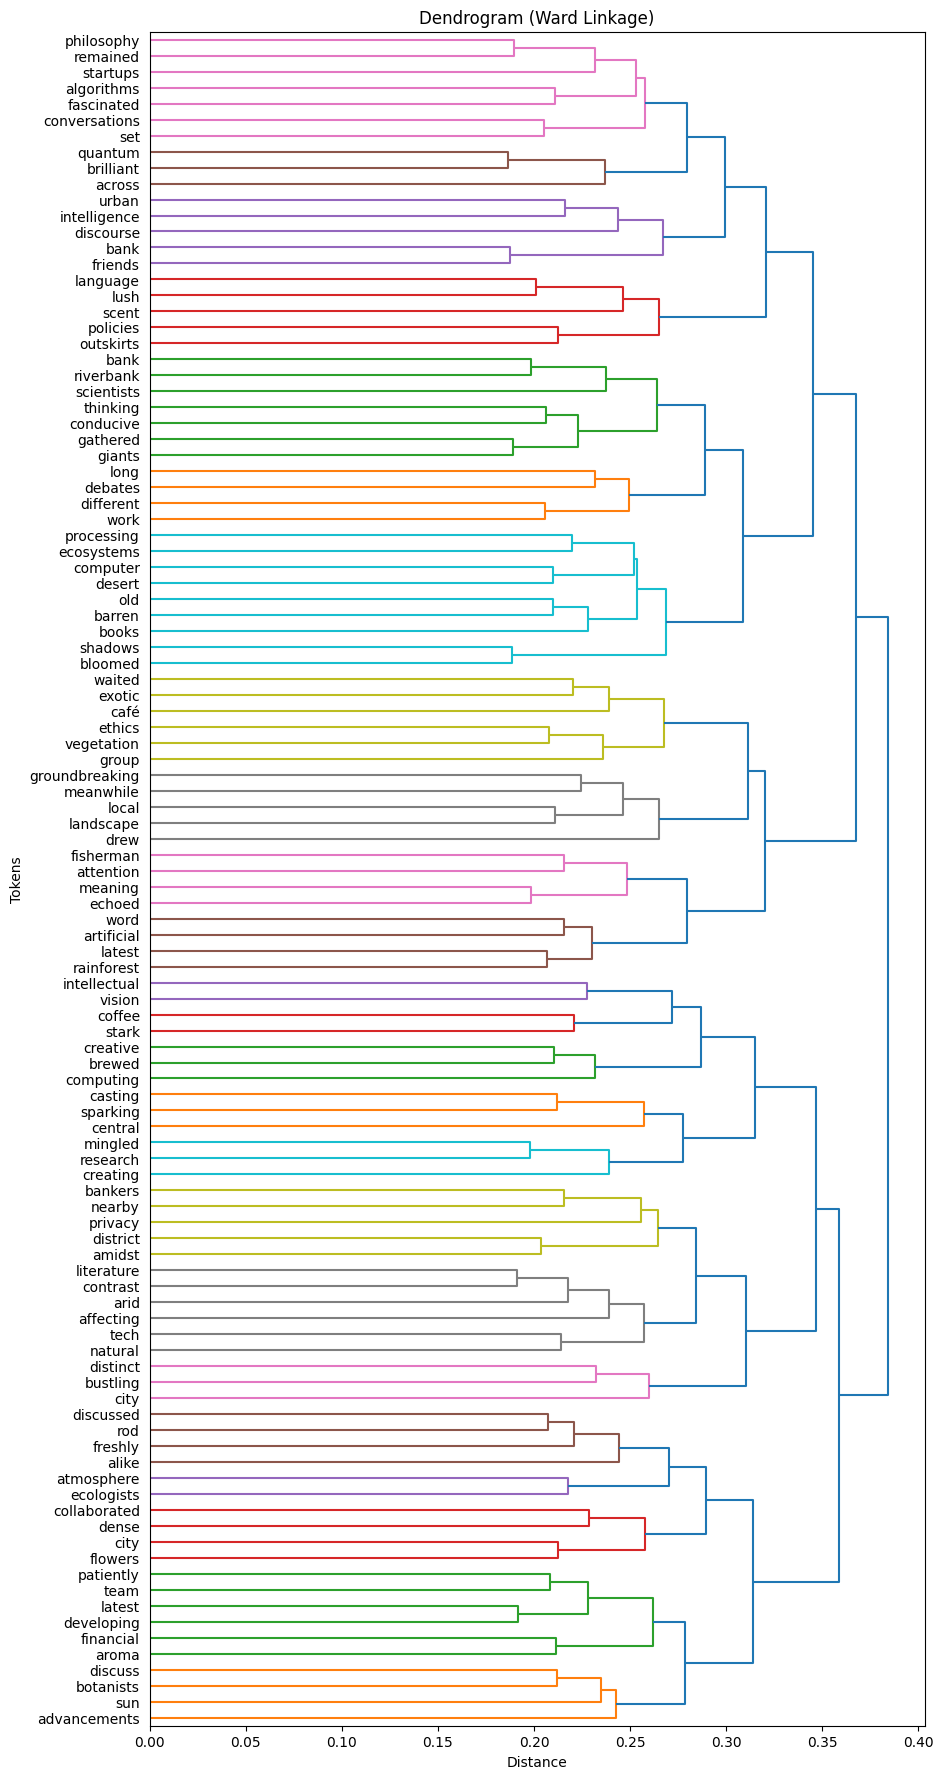

Dendrogram for Word2Vec Embeddings


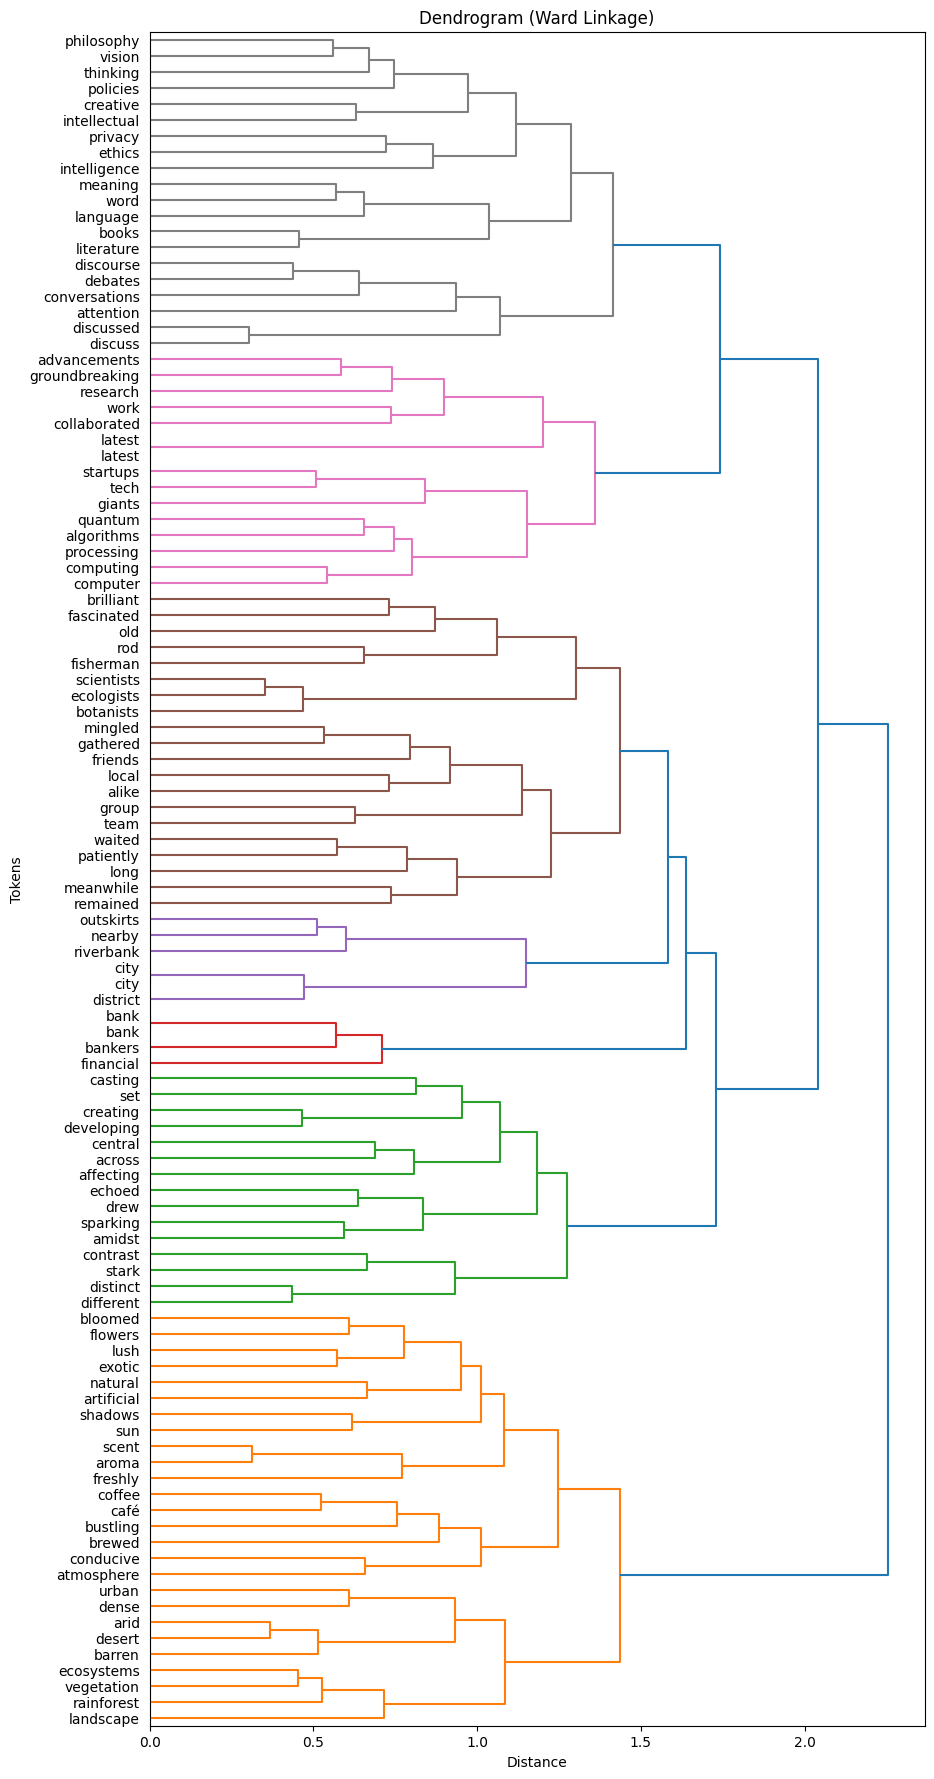

Dendrogram for BERT-based Embeddings


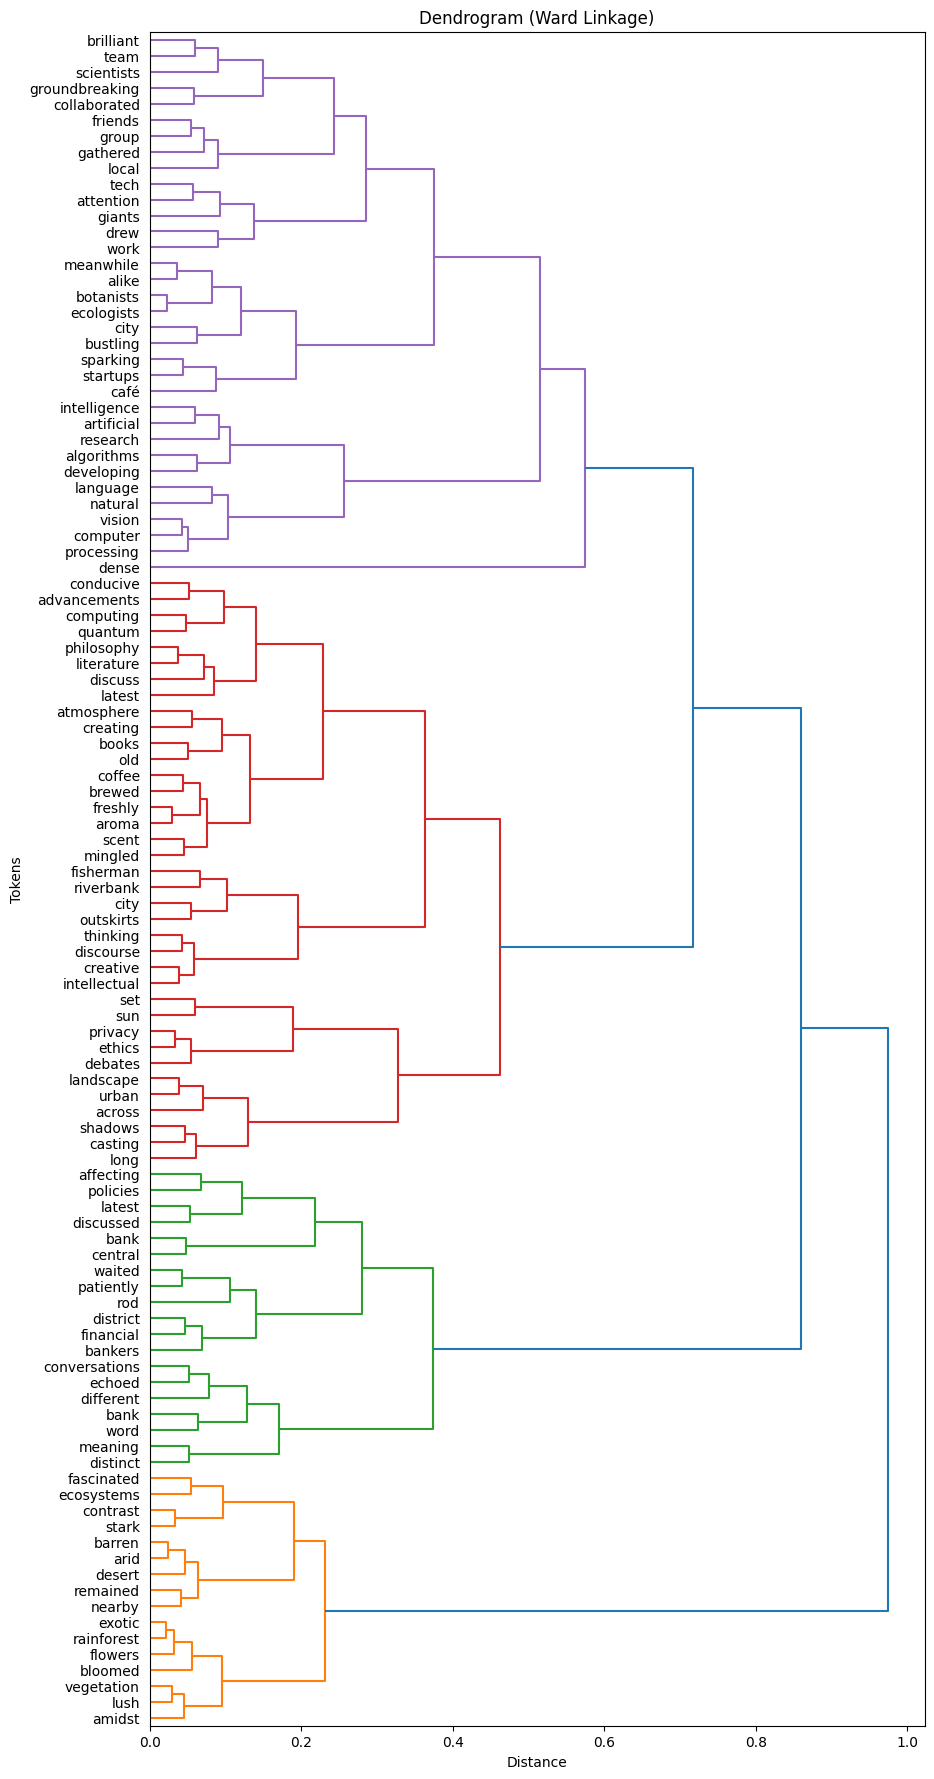

Dendrogram for Encoded Ones Embeddings


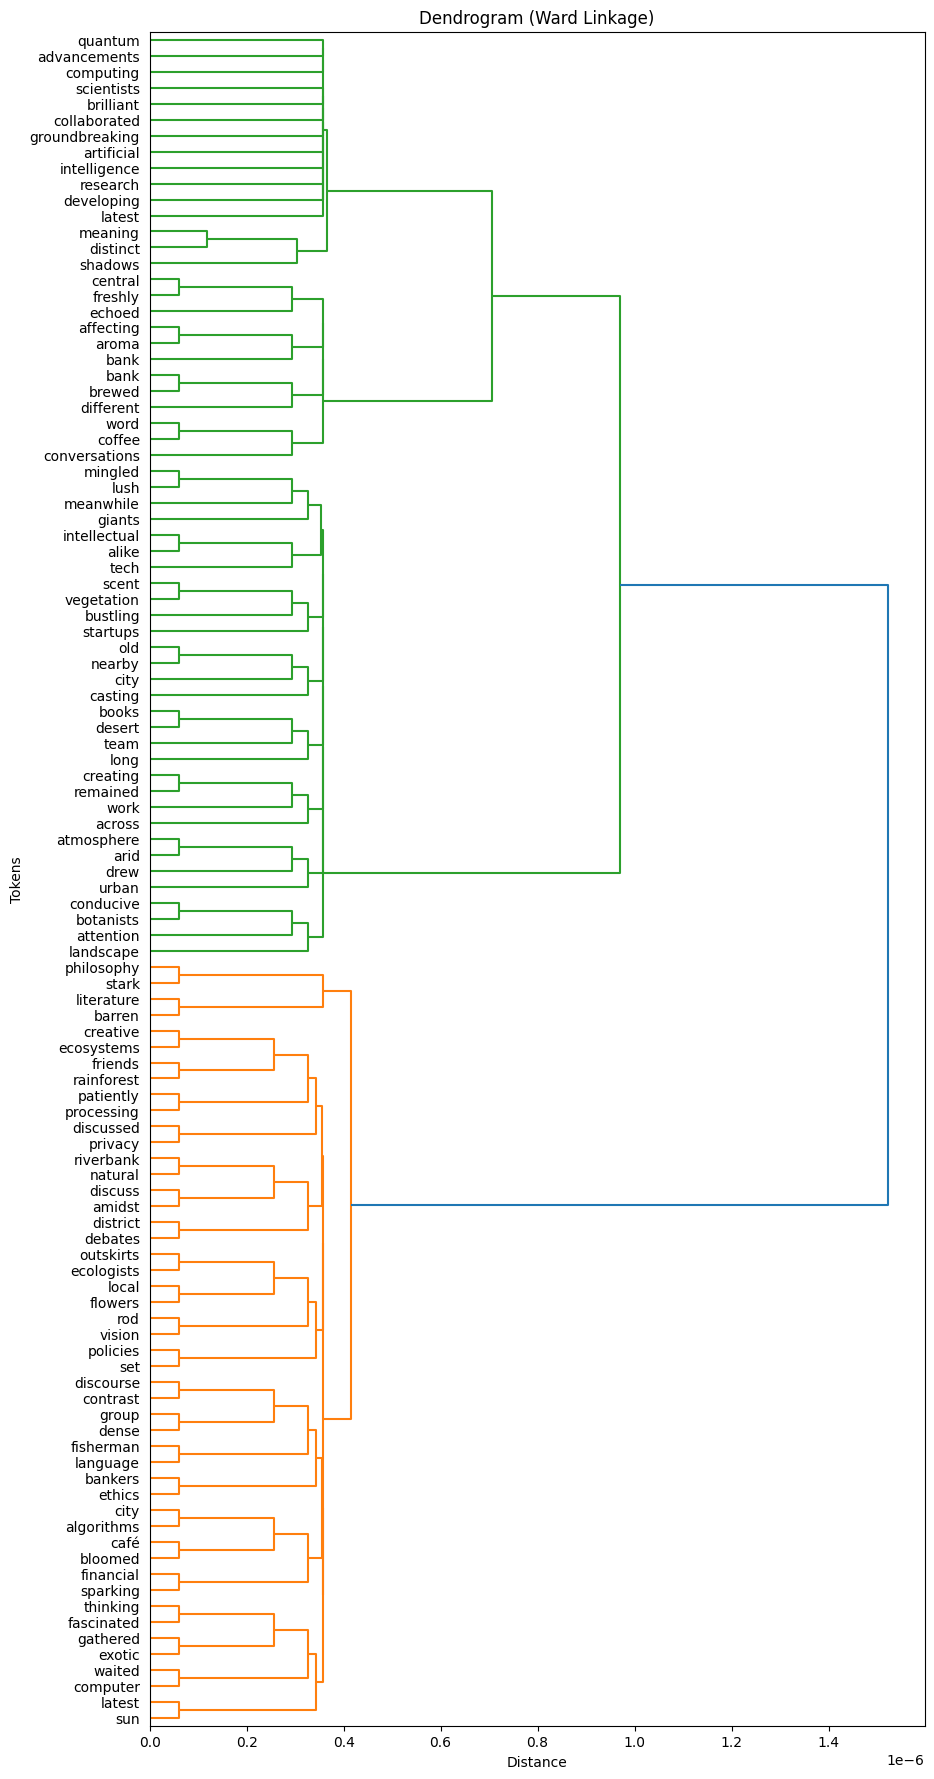

Dendrogram for Encoded Word2Vec Embeddings


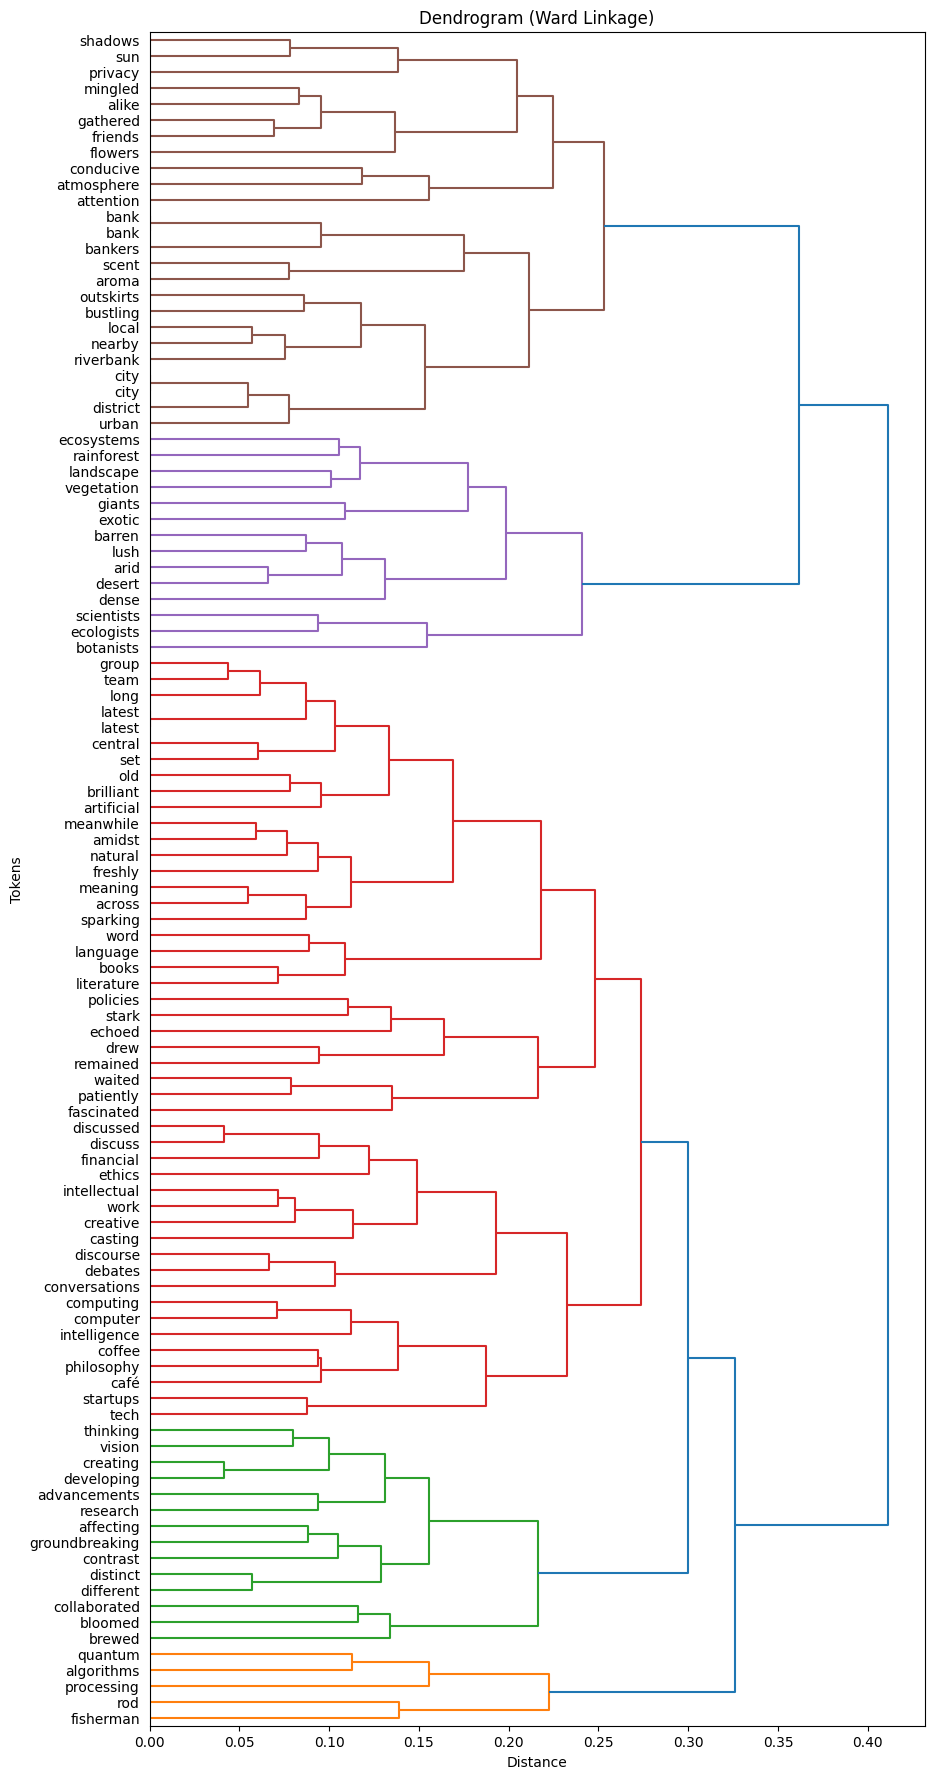

In [15]:
def main():
    text = corpus
    all_tokens, filtered_tokens = tokenizer(text)

    # Generate embeddings
    random_embeddings, _ = get_random_embeddings(filtered_tokens)
    w2v_embeddings, _ = get_w2v_embeddings(filtered_tokens, w2v)
    attention_embeddings = get_attention_embeddings(filtered_tokens)
    
    # Create np.ones embeddings
    ones_embeddings = np.ones((len(filtered_tokens), 300))
    
    # Initialize and process embeddings with the custom transformer encoder
    stacked_encoder = StackedEncoder(num_layers, d_model, num_heads, d_ffn, dropout).to(device)
    encoded_ones_embeddings = process_embeddings_with_encoder(ones_embeddings, stacked_encoder)
    encoded_w2v_embeddings = process_embeddings_with_encoder(w2v_embeddings, stacked_encoder)

    # UMAP visualizations
    umap_random_embeddings, umap_random_embeddings_3d = visualize_embeddings_umap(random_embeddings, filtered_tokens)
    umap_w2v_embeddings, umap_w2v_embeddings_3d = visualize_embeddings_umap(w2v_embeddings, filtered_tokens)
    umap_attention_embeddings, umap_attention_embeddings_3d = visualize_embeddings_umap(attention_embeddings, filtered_tokens)
    umap_encoded_ones_embeddings, umap_encoded_ones_embeddings_3d = visualize_embeddings_umap(encoded_ones_embeddings, filtered_tokens)
    umap_encoded_w2v_embeddings, umap_encoded_w2v_embeddings_3d = visualize_embeddings_umap(encoded_w2v_embeddings, filtered_tokens)

    # Find closest tokens
    closest_token = 'artificial'
    top_n = 5

    closest_to_token_random = get_closest_tokens(closest_token, random_embeddings, filtered_tokens, top_n=top_n)
    closest_to_token_w2v = get_closest_tokens(closest_token, w2v_embeddings, filtered_tokens, top_n=top_n)
    closest_to_token_bert = get_closest_tokens(closest_token, attention_embeddings, filtered_tokens, top_n=top_n)
    closest_to_token_encoded_ones = get_closest_tokens(closest_token, encoded_ones_embeddings, filtered_tokens, top_n=top_n)
    closest_to_token_encoded_w2v = get_closest_tokens(closest_token, encoded_w2v_embeddings, filtered_tokens, top_n=top_n)
    
    # Collect the indices of the closest tokens
    closest_indices_random = [index for _, _, index in closest_to_token_random]
    closest_indices_w2v = [index for _, _, index in closest_to_token_w2v]
    closest_indices_bert = [index for _, _, index in closest_to_token_bert]
    closest_indices_encoded_ones = [index for _, _, index in closest_to_token_encoded_ones]
    closest_indices_encoded_w2v = [index for _, _, index in closest_to_token_encoded_w2v]

    # Combine all the indices from the embedding types
    all_closest_indices = list(set(closest_indices_random + closest_indices_w2v + closest_indices_bert + closest_indices_encoded_ones + closest_indices_encoded_w2v))
    
    # Ensure the query token itself is included in the list
    query_token_index = filtered_tokens.index(closest_token)
    if query_token_index not in all_closest_indices:
        all_closest_indices.append(query_token_index)
    
    # Filter the UMAP embeddings and tokens to create a smaller dataset
    filtered_tokens_selected = [filtered_tokens[i] for i in all_closest_indices]
    
    umap_random_selected = umap_random_embeddings[all_closest_indices]
    umap_w2v_selected = umap_w2v_embeddings[all_closest_indices]
    umap_attention_selected = umap_attention_embeddings[all_closest_indices]
    umap_encoded_ones_selected = umap_encoded_ones_embeddings[all_closest_indices]
    umap_encoded_w2v_selected = umap_encoded_w2v_embeddings[all_closest_indices]
    
    # Concatenate embeddings for x and y
    x_concatenated = np.concatenate((umap_random_selected[:, 0], umap_w2v_selected[:, 0], umap_attention_selected[:, 0], umap_encoded_ones_selected[:, 0], umap_encoded_w2v_selected[:, 0]))
    y_concatenated = np.concatenate((umap_random_selected[:, 1], umap_w2v_selected[:, 1], umap_attention_selected[:, 1], umap_encoded_ones_selected[:, 1], umap_encoded_w2v_selected[:, 1]))
    animation_concatenated = ['random'] * len(filtered_tokens_selected) + ['w2v'] * len(filtered_tokens_selected) + ['BERT'] * len(filtered_tokens_selected) + ['encoded_ones'] * len(filtered_tokens_selected) + ['encoded_w2v'] * len(filtered_tokens_selected)

    # Create DataFrame
    data = {
        'token': filtered_tokens_selected * 5,  # Repeat tokens for each embedding type
        'x': x_concatenated,
        'y': y_concatenated,
        'animation_frame': animation_concatenated
    }

    df = pd.DataFrame(data)

    # Call the animation function
    create_animation(df, closest_token)
    
    # Plot dendrograms for each type of embedding
    print("Dendrogram for Random Embeddings")
    plot_dendrogram(random_embeddings, filtered_tokens, method='ward')
    print("Dendrogram for Word2Vec Embeddings")
    plot_dendrogram(w2v_embeddings, filtered_tokens, method='ward')
    print("Dendrogram for BERT-based Embeddings")
    plot_dendrogram(attention_embeddings, filtered_tokens, method='ward')
    print("Dendrogram for Encoded Ones Embeddings")
    plot_dendrogram(encoded_ones_embeddings, filtered_tokens, method='ward')
    print("Dendrogram for Encoded Word2Vec Embeddings")
    plot_dendrogram(encoded_w2v_embeddings, filtered_tokens, method='ward')

if __name__ == "__main__":
    main()